#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.5em; color:#00b3e5;"> WaveNet - Stock Market Prediction

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Libraries

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow       as   tf
from   tensorflow     import keras
from keras.models     import Sequential
from keras.layers     import LSTM, Dropout, Dense, Activation, SimpleRNN, TimeDistributed
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Importing Data

In [2]:
Project_Name = 'Google_Stock_Price'

data = pd.read_csv('Google_Stock_Price.csv')
data.head(3)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"


In [3]:
C = data[['Close']].copy()
for i in range(C.shape[0]):
    C.loc[i,'Close'] = C.loc[i,'Close'].replace(",","") 

In [4]:
TimeSeries         = C.astype(float)
TimeSeries.index   = pd.to_datetime( data['Date'].values, format='%m/%d/%Y')
TimeSeries.columns =     ['Series']
TimeSeries.tail(3)

,Series
2016-12-28,785.05
2016-12-29,782.79
2016-12-30,771.82


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Smooting Series & Noisy Seasonality

In [5]:
''' 
def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, TimeSeries.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, TimeSeries.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise
''' 

def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

smoothed, noise = smoother( TimeSeries, 'Series', 20 )

TimeSeries[ 'Smoothed_Series' ] = np.round( smoothed, 0 ) 
TimeSeries['Noisy_Seasonality'] = np.round( noise, 0 )  
TimeSeries.tail(3)

,Series,Smoothed_Series,Noisy_Seasonality
2016-12-28,785.05,777.0,8.0
2016-12-29,782.79,774.0,8.0
2016-12-30,771.82,772.0,0.0


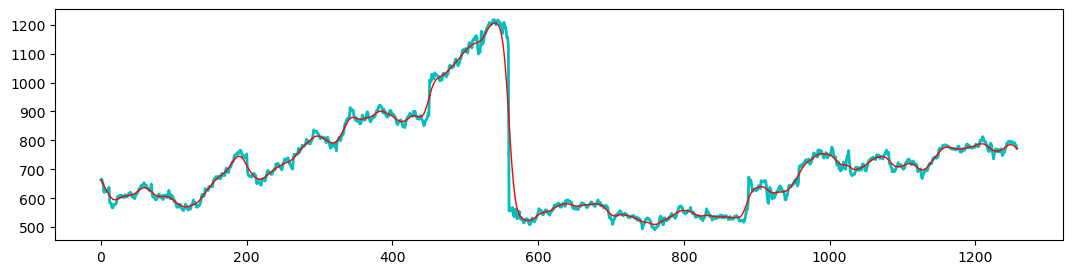

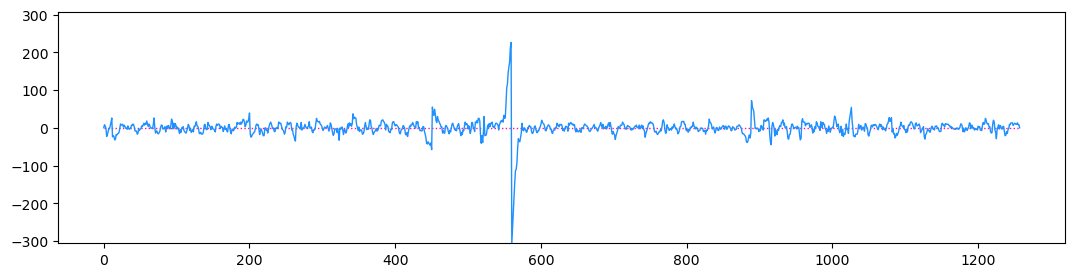

In [6]:
Range = range(TimeSeries.shape[0])
plt.figure(figsize=(13,3))
plt.plot(Range,TimeSeries['Series'],color='c',linewidth=2 ) 
plt.plot(Range,TimeSeries['Smoothed_Series'],color='r',linewidth=1) 
plt.show()

plt.figure(figsize=(13,3))
plt.plot( [Range[0],Range[-1]],   [0,0],      color='deeppink',   linewidth=1, linestyle=':' )
plt.plot(  Range,  TimeSeries['Noisy_Seasonality'], color='dodgerblue', linewidth=1  ) 
mx=max(abs(TimeSeries['Noisy_Seasonality']));plt.gca().set_ylim(-mx,+mx)
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> FFT & Clean Seasonality

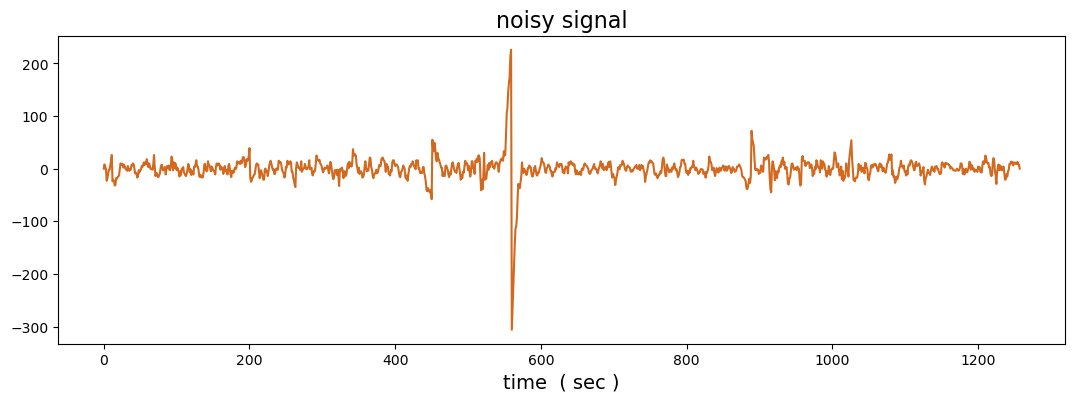

In [7]:
from scipy.fftpack import fft, fftfreq, ifft

#noisy_signal = smoothed.copy()
noisy_signal = pd.DataFrame(TimeSeries['Noisy_Seasonality'].values.copy())
dt = 1

# (auto) Time Domain
t0 = 0
t1 = len( noisy_signal )*dt
t  = np.arange(t0,t1,dt)
n  = len(t)

# (auto) Plot  noisy_signal : time
plt.figure( figsize=(13,4) )
plt.plot( t, noisy_signal, color='chocolate', linewidth=1.5 ) 
plt.title('noisy signal',fontsize=16) 
plt.xlabel("time  ( sec )", fontsize=14)
#plt.savefig('Noisy_Signal.png', dpi=120) 
plt.show()

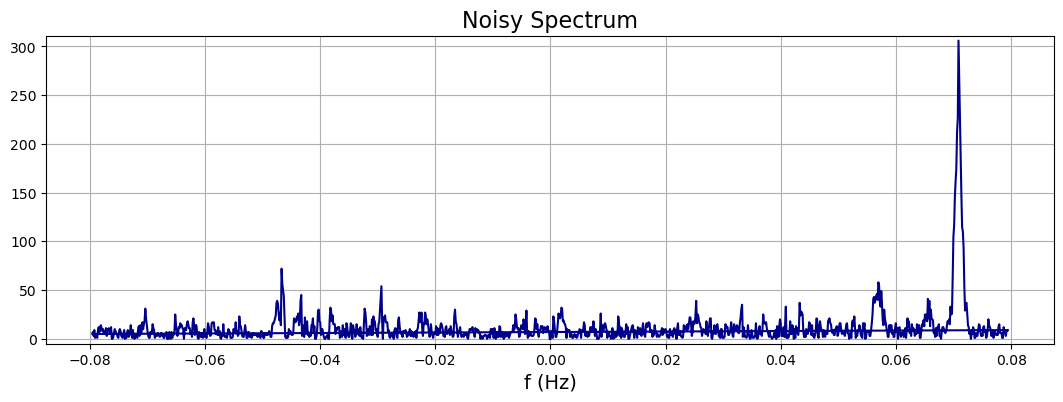

In [8]:
# (auto) Frequency Domain, f (Hz)
f_Hz  = fftfreq(n,dt) /(2*np.pi)

# (auto) Noisy Spectrum
noisy_spec     = fft( noisy_signal )    # ( r + i )            
noisy_spec_val = np.abs( noisy_spec )   # ( r^2 + i^2 )^.5

# (auto) plot  noisy_spec : f_Hz 
plt.figure( figsize=(13,4) )
plt.plot(  f_Hz, noisy_spec_val, color='darkblue', linewidth=1.5 )  
plt.title("Noisy Spectrum",fontsize=16)
plt.xlabel('f (Hz)',fontsize=14)
mx=max(abs(noisy_spec_val));plt.gca().set_ylim(-5,+mx+5)
#plt.xlim(0,)  
#plt.savefig('Noisy_Spectrum.png', dpi=120)
plt.grid(True)
plt.show()

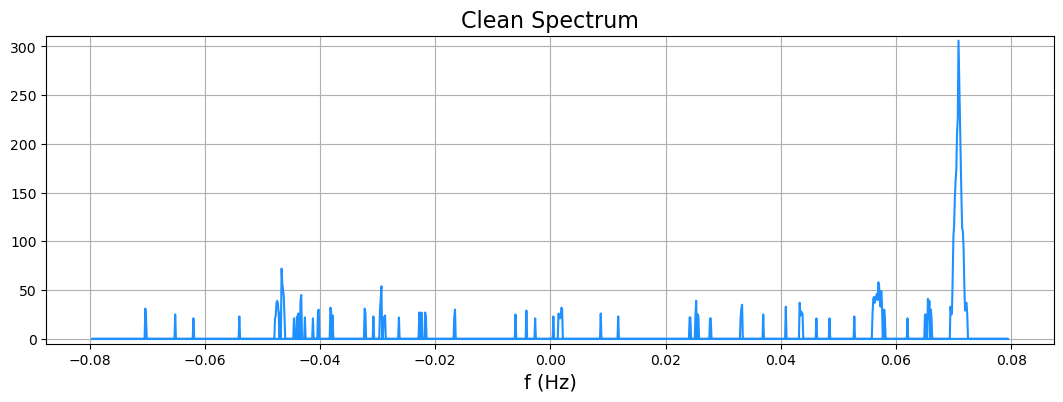

In [9]:
Threshhold = 20

# (auto) removing the noise    
indices        = noisy_spec_val > Threshhold   # filters out those value under Threshhold
clean_spec     = indices * noisy_spec          # Noise Frequency will be set to 0           
clean_spec_val = np.abs( clean_spec )

# (auto) plot  clean_spec : f_Hz 
plt.figure( figsize=(13,4) )
plt.plot(  f_Hz, clean_spec_val, color='dodgerblue', linewidth=1.5 )  
plt.title("Clean Spectrum",fontsize=16)
plt.xlabel('f (Hz)',fontsize=14)
mx=max(abs(clean_spec_val));plt.gca().set_ylim(-5,+mx+5)
#plt.xlim(0,)
#plt.savefig('Clean_Spectrum.png', dpi=120) 
plt.grid(True)
plt.show()

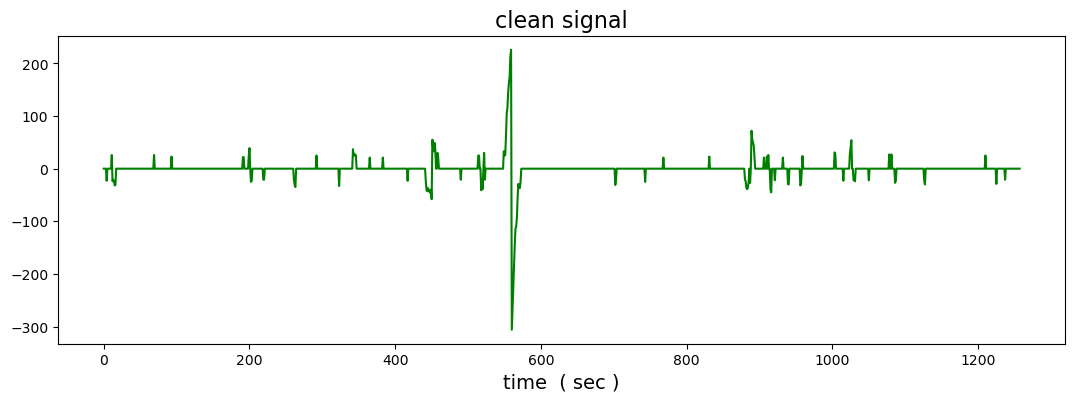

In [10]:
# (auto) inverse back to time domain data
clean_signal = ifft( clean_spec )

# (auto) Plot  clean_signal : time
plt.figure( figsize=(13, 4) )
plt.plot( t, np.real(clean_signal), color='green', linewidth=1.5 )
plt.title('clean signal',fontsize=16) 
plt.xlabel("time  ( sec )", fontsize=14)
#plt.savefig('Clean_Signal.png', dpi=120)
plt.show() 

In [11]:
TimeSeries[  'Clean_Seasonality'  ] = np.round( np.real(clean_signal), 0 )  
TimeSeries.tail(3)

,Series,Smoothed_Series,Noisy_Seasonality,Clean_Seasonality
2016-12-28,785.05,777.0,8.0,0.0
2016-12-29,782.79,774.0,8.0,0.0
2016-12-30,771.82,772.0,0.0,0.0


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Seasonality

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Extracting Y, M, D from Dates

In [12]:
Dates = TimeSeries.index.date.tolist()
Dates[:3]

[datetime.date(2012, 1, 3),
 datetime.date(2012, 1, 4),
 datetime.date(2012, 1, 5)]

In [13]:
Dates = pd.to_datetime(Dates, format='%m/%d/%Y')
Dates[:3]

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05'], dtype='datetime64[ns]', freq=None)

In [14]:
df = pd.DataFrame()
df['Year' ] = Dates.year
df['month'] = Dates.month
df[ 'day' ] = Dates.day
df.index = Dates
df.sample(3)

,Year,month,day
2016-05-04,2016,5,4
2016-04-11,2016,4,11
2014-12-12,2014,12,12


In [15]:
Seasons = pd.concat([df,TimeSeries],axis=1) 
Seasons.tail(3)

,Year,month,day,Series,Smoothed_Series,Noisy_Seasonality,Clean_Seasonality
2016-12-28,2016,12,28,785.05,777.0,8.0,0.0
2016-12-29,2016,12,29,782.79,774.0,8.0,0.0
2016-12-30,2016,12,30,771.82,772.0,0.0,0.0


<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Visualizing Seasonality

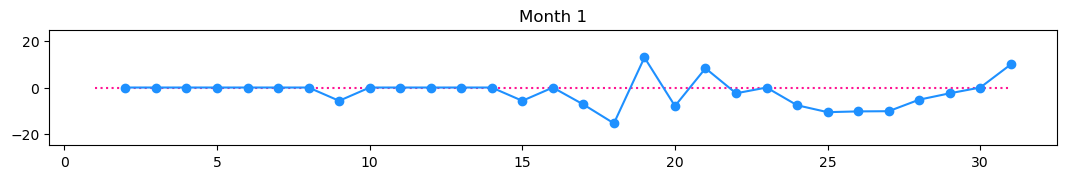

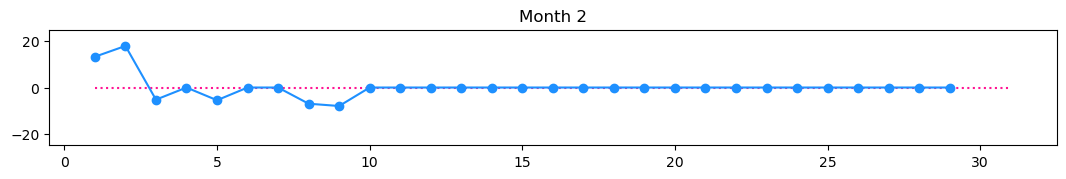

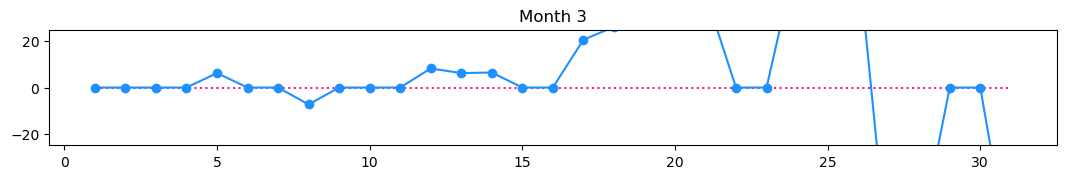

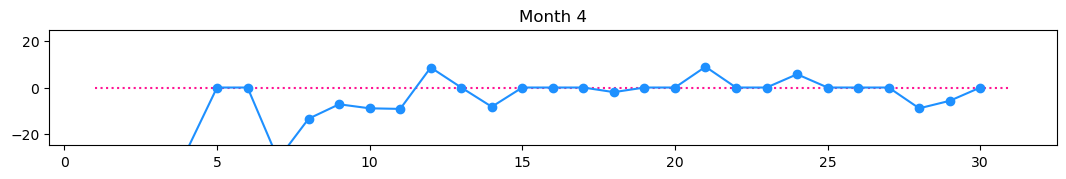

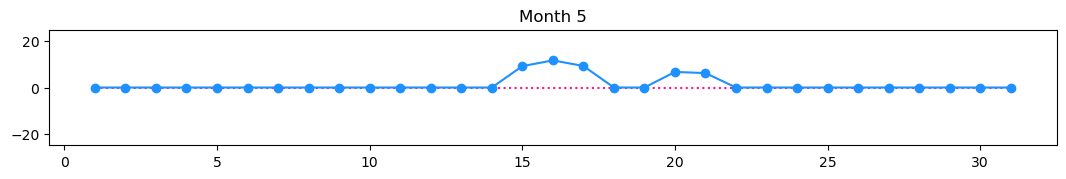

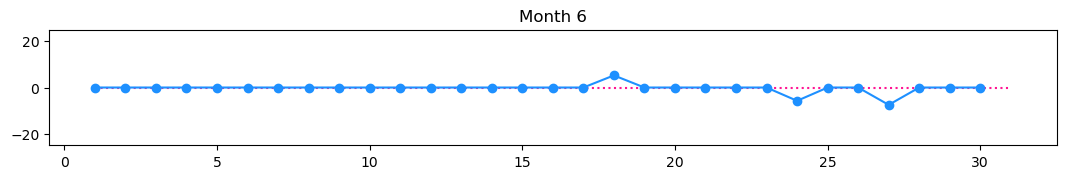

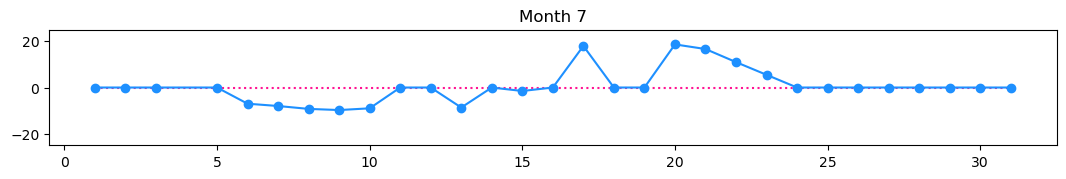

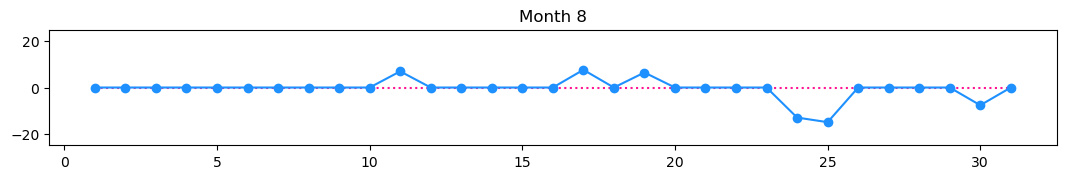

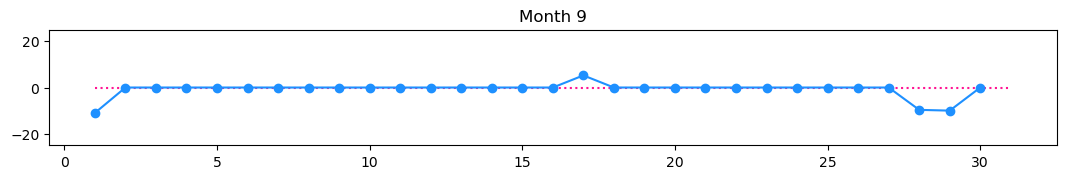

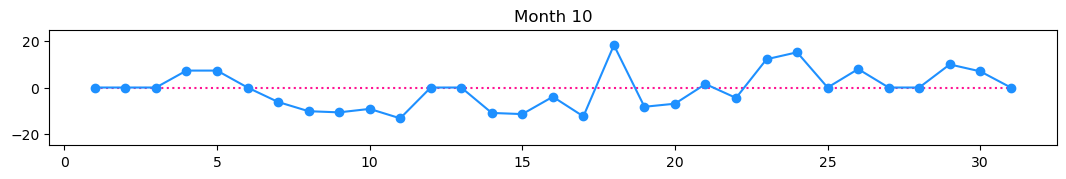

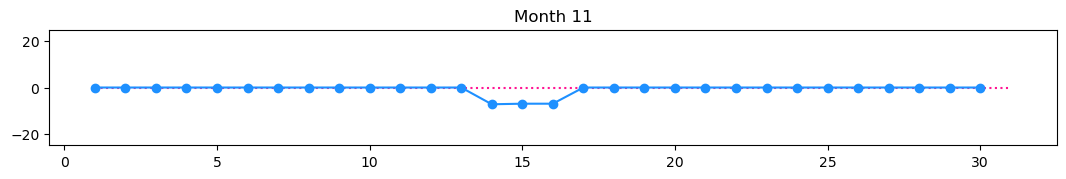

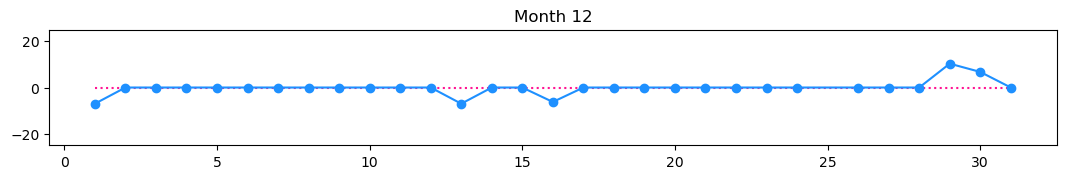

In [17]:
def plot_monthly_seasonality( df, ft, Month ): 
    A = df.loc[ df['month']==Month, ['day',ft] ].groupby('day').mean() 
    plt.figure(figsize=(13,1.5))
    plt.plot( [1,31],  [0,0], ':',  color='deeppink'   )
    plt.plot( A.index, A[ft], '-o', color='dodgerblue' )  
    plt.gca().set_ylim(-25,+25)
    plt.title('Month '+str(Month))
    plt.show()
    
for i in range(1,13):
    plot_monthly_seasonality( Seasons, 'Clean_Seasonality', i )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Smoothed Series

In [18]:
# functions
# Time-Series Generator
def generate_time_series( bSize, nSteps ):  
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, bSize, 1)
    time = np.linspace(0, 1, nSteps)
    series  = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))     #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
    series += 0.1 * (np.random.rand(bSize, nSteps) - 0.5)             # + noise
    return series[..., np.newaxis].astype(np.float32)

# last_time_step_mse
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [19]:
S = TimeSeries[['Smoothed_Series']].values.astype('float32') 
S = S[:,0]
S

array([664., 659., 654., ..., 777., 774., 772.], dtype=float32)

In [20]:
def under_under( S ): 
    A = [];
    for i in S:
        A.append([i])
    return A

A = under_under( S.copy() )  

In [65]:
# New_Series
import random as random

def New_Series( A ):
    New = A.copy()
    n = len(New)
    for i in range(n):  
        r = random.uniform(0.98,1.02)
        New[i][0] = New[i][0] * r
    return New   

B = New_Series( A )  
A = under_under( S ) 

In [66]:
N      = 30
nBatch = 1000  

Series = []
for i in range( nBatch+N ):
    A = under_under( S ) 
    Series.append( New_Series( A ) ) 
Series = np.array(Series) 

In [67]:
# (3) Best   WaveNet 
series = Series.copy()
bSize  = series.shape[0]
nSteps = series.shape[1]-N
n_neurons = max( [20,2*N] )

a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 



model = keras.models.Sequential()

model.add( keras.layers.InputLayer(input_shape=[None, 1]) )

for rate in (1, 2, 4, 8) * 2:
    model.add( keras.layers.Conv1D( filters       =  n_neurons   # default is 20
                                  , kernel_size   =   2
                                  , padding       = "causal"
                                  , activation    = "relu"
                                  , dilation_rate =  rate
                                  ))

model.add( keras.layers.Conv1D(     filters       =  N   # default is 10
                                  , kernel_size   =  1    ))


print('Model Defined.')

Model Defined.


In [104]:
# load weights
version = 'BEST'
 
model.load_weights( Project_Name + '_' + version 
                  , by_name = False 
                  , skip_mismatch = False 
                  , options = None 
                  )

In [137]:
model.compile( loss      = "mse"
             , optimizer = "adamax"     # 'sgd' 'adam' 'nadam' 'adamax'
             , metrics   = [last_time_step_mse]
             )
history = model.fit( X_train, Y_train
                   , epochs          =  10
                   , validation_data = (X_valid, Y_valid)
                   )

Epoch 1/10
23/23 [==============================] - 20s 770ms/step - loss: 13743.3389 - last_time_step_mse: 11915.2500 - val_loss: 4626.6553 - val_last_time_step_mse: 2348.2534
Epoch 2/10
23/23 [==============================] - 17s 749ms/step - loss: 3847.7527 - last_time_step_mse: 1136.2681 - val_loss: 3240.9087 - val_last_time_step_mse: 645.4407
Epoch 3/10
23/23 [==============================] - 17s 753ms/step - loss: 3113.6194 - last_time_step_mse: 1097.2030 - val_loss: 3017.8467 - val_last_time_step_mse: 988.8570
Epoch 4/10
23/23 [==============================] - 17s 751ms/step - loss: 2984.5156 - last_time_step_mse: 943.8432 - val_loss: 2956.7786 - val_last_time_step_mse: 993.0377
Epoch 5/10
23/23 [==============================] - 18s 803ms/step - loss: 2933.5420 - last_time_step_mse: 996.7487 - val_loss: 2913.0015 - val_last_time_step_mse: 988.4037
Epoch 6/10
23/23 [==============================] - 17s 757ms/step - loss: 2893.7229 - last_time_step_mse: 964.3456 - val_loss: 2

In [138]:
Y_pred = model.predict(X_test)   
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nRMSE =',np.round(MSE**.5,4))

4/4 [==============================] - 1s 157ms/step

RMSE = 52.7578


In [139]:
# save weights
version = '03'

model.save_weights( Project_Name + '_' + version
                  , overwrite = True 
                  , save_format = None 
                  , options = None 
                  )

In [140]:
# load weights
version = '03'
 
model.load_weights( Project_Name + '_' + version 
                  , by_name = False 
                  , skip_mismatch = False 
                  , options = None 
                  )

In [141]:
A = np.array([ under_under(  S  ) ])   # either (the same)
#A = np.array([ under_under( S[N:] ) ])   #   or   (the same)

Y_preds = model.predict( A ) 
Preds = np.round( Y_preds[-1][-1],0 )

1/1 [==============================] - 0s 486ms/step


In [153]:

df_Preds = pd.DataFrame()
df_Preds['Preds'] = Preds

def smoother( df, ft, n ):
    s = df[ft].values.copy()
    for i in range(n): 
        for i in np.arange( 2, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
        for i in np.arange( 1, df.shape[0]-1, 2 ):
            s[i] = ( s[i-1]+s[i+1] ) / 2
    noise = df[ft].values.copy() - s
    return s, noise

Smoothed_Preds, Noise = smoother( df_Preds, 'Preds', 5 )
Smoothed_Preds = np.round( Smoothed_Preds, 0 ) 
Smoothed_Preds# Smoothing Predictions

array([768., 768., 767., 766., 766., 765., 764., 763., 762., 761., 760.,
       759., 759., 758., 757., 757., 756., 756., 756., 755., 755., 755.,
       754., 754., 753., 753., 753., 753., 753., 754.], dtype=float32)

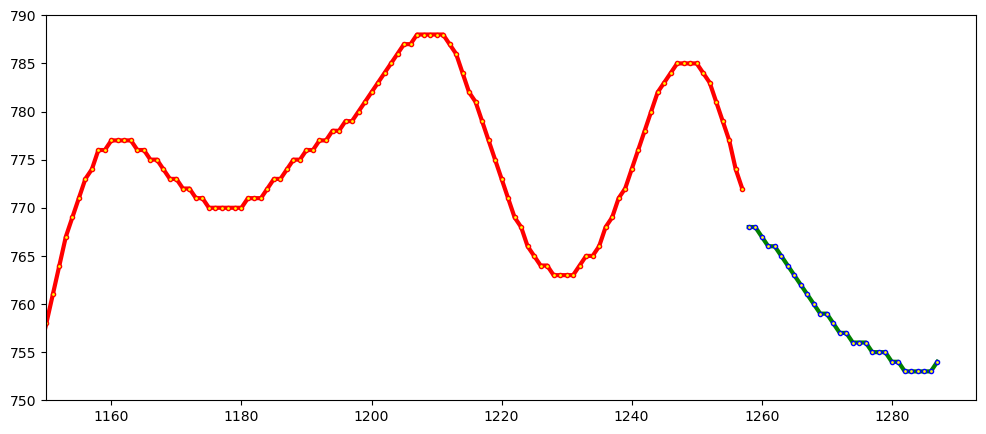

In [154]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(  range(len(S)), S
        , lw=3, c='r', ls='-'
        , marker='o', markersize=3
        , mec='red' , mew=1, mfc='yellow')

ax.plot(  np.arange(len(S),len(S)+N), Smoothed_Preds
        , lw=3, c='g', ls='-'
        , marker='o', markersize=3
        , mec='blue', mew=1, mfc='yellow' )
#plt.xlim([-20,len(S)+N+20])
#plt.ylim([0,1300])
plt.xlim([1150,len(S)+N+5])
plt.ylim([750,790])

plt.savefig( Project_Name+'_Version_'+version+'_.png', dpi=120 )
plt.show()

#####   

#####   

In [144]:
## save weights
#version = 'BEST'    # RMSE = 52.8
#model.save_weights( Project_Name+'_'+version, overwrite=True, save_format=None, options=None )

#####   